In [23]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [24]:
data_dir = '../Training_Data/Moseley_Homogeneous_Big/'
data_csv = '../Training_Data/Moseley_Homogeneous_Big_Event0000_Continuous.csv'
event = 'Event0000'

training_data = dataset(data_dir,data_csv,event)

sample = training_data.__getitem__(0)

input = sample['wave_input'].transpose(1,0)
output = sample['wave_output'].transpose(1,0)

inputs = torch.cat((input,output),axis=0) # 5 inputs channels

## FINITE DIFFERENCE

In [25]:
dh = 5
dt = 0.0002

c = 2200

P = (dt ** 2) * (c ** 2)/(dh ** 2)

# x FD
x = np.array([[ 0,  0,  0],
              [ 1, -2,  1],
              [ 0,  0,  0]])

# y FD
y = np.array([[ 0,  1,  0],
              [ 0, -2,  0],
              [ 0,  1,  0]])

In [26]:
conv_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv_x.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))
conv_x = conv_x.to(device)

conv_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv_y.weight=nn.Parameter(torch.from_numpy(y).float().unsqueeze(0).unsqueeze(0))
conv_y = conv_y.to(device)

In [27]:
u_n = inputs[-2:-1,:,:][None].to(device)
u_n_1 = inputs[-3:-2,:,:][None].to(device)

In [28]:
u_dxdx = conv_x(u_n).cpu().detach().numpy()[0,0]
u_dydy = conv_y(u_n).cpu().detach().numpy()[0,0]

u_n = u_n.cpu().detach().numpy()[0,0]
u_n_1 = u_n_1.cpu().detach().numpy()[0,0]

In [29]:
next_u = P * u_dxdx + P * u_dydy + 2 * u_n - u_n_1

In [30]:
inputs[-1]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Text(0.5, 1.0, 'Error')

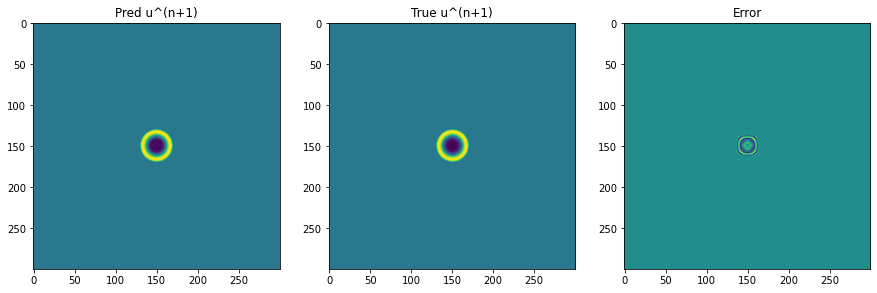

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

# Predicted with FD
ax[0].imshow(next_u)
ax[0].set_title('Pred u^(n+1)')

# True output
ax[1].imshow(inputs[-1])
ax[1].set_title('True u^(n+1)')

# Error
ax[2].imshow(next_u-inputs[-1].detach().numpy())
ax[2].set_title('Error')

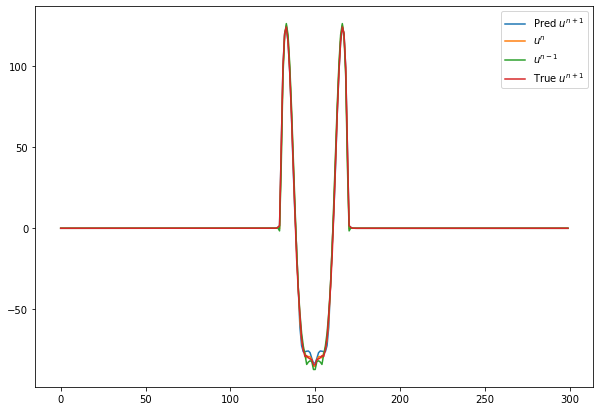

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

# Predicted next TS with FD
plt.plot(next_u[150,:],label='Pred $u^{n+1}$')

# Previous TS 
plt.plot(u_n[150,:],label='$u^{n}$')
plt.plot(u_n_1[150,:],label='$u^{n-1}$')

# True next TS from Salvus
plt.plot(output[0].detach().numpy()[150,:],label='True $u^{n+1}$')

plt.legend()